# Mission

Pair trading is a market-neutral trading strategy, enabling one to profit from almost any market condition, based on the historical cointegration of a pair of stocks. Shub Jain from Auquan [has written](https://medium.com/auquan/pairs-trading-data-science-7dbedafcfe5a) a great description of the principle, as well as a thorough explanation of creating a basic implementation. My task is to build on that foundation a more effective model. The modifications I shall make are the following:
1. Trading only discrete shares, because in reality shares are discrete, not continuous.
2. Trading long only, as I currently want to keep things simple by staying with stocks, not venturing into options.
3. Spreading the selling and buying over a few consecutive days.

In addition, I will optimize the model's parameters simply using grid search and heatmaps.

In [62]:
import yfinance as yf 
import numpy as np
import itertools as it
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from math import floor, fmod

# Selecting a cointegrated pair

In order to prevent multiple comparison bias, it is best to not compare a huge amount of stocks, but to pick a few that one suspects of being cointegrated. The most natural set of cointegrated pairs are groups of companies in the same fields. As such, lets pick some IT companies from S&P 500.

In [83]:
instrument_ids = ['ADBE', 'AMD', 'AVGO', 'BSX', 'CDNS', 'CRM', 'HPQ', 'INTC', 'JNPR', 'MSFT', 'SPY']
start_date = '2010-06-07'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(instrument_ids, start_date, end_date)['Adj Close']
data = data.interpolate()

[*********************100%***********************]  11 of 11 completed


It ought to be noted that I included the market benchmark (SPY) too. As explained in the article that inspired this project, the reason for this is that

  >"the market drives the movement of so many securities that often you might find two seemingly cointegrated securities; but in reality they are not cointegrated with each other but both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find."
  
Plotting a heatmap of the p-values of the cointegration. The closer the p-value is to 0, the more certain we can be of the pair truly being cointegrated.  

In [84]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

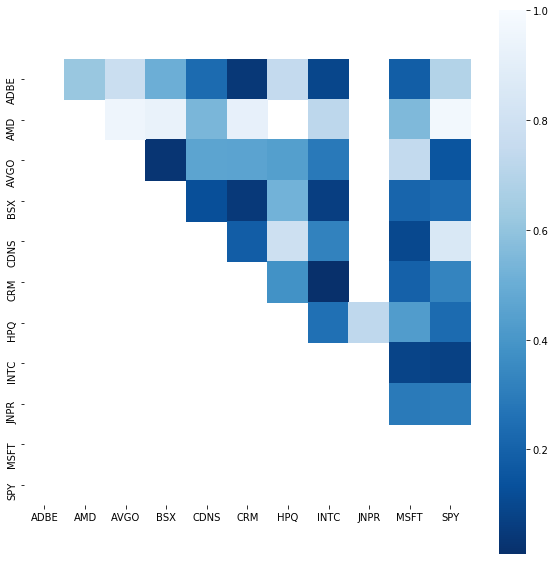

In [85]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=instrument_ids, 
                yticklabels=instrument_ids, cmap='Blues_r',
                mask = (pvalues >= 0.98))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_aspect("equal")

There are hence a few promising candidate pairs. Despite their not being the darkest pair, I shall choose MSFT and ADBE, as it is the only one of the candidates where the conitegration of each one with the market (SPY) is negligible. 

Now lets intuitively ascertain the cointegration by viewing the two series.

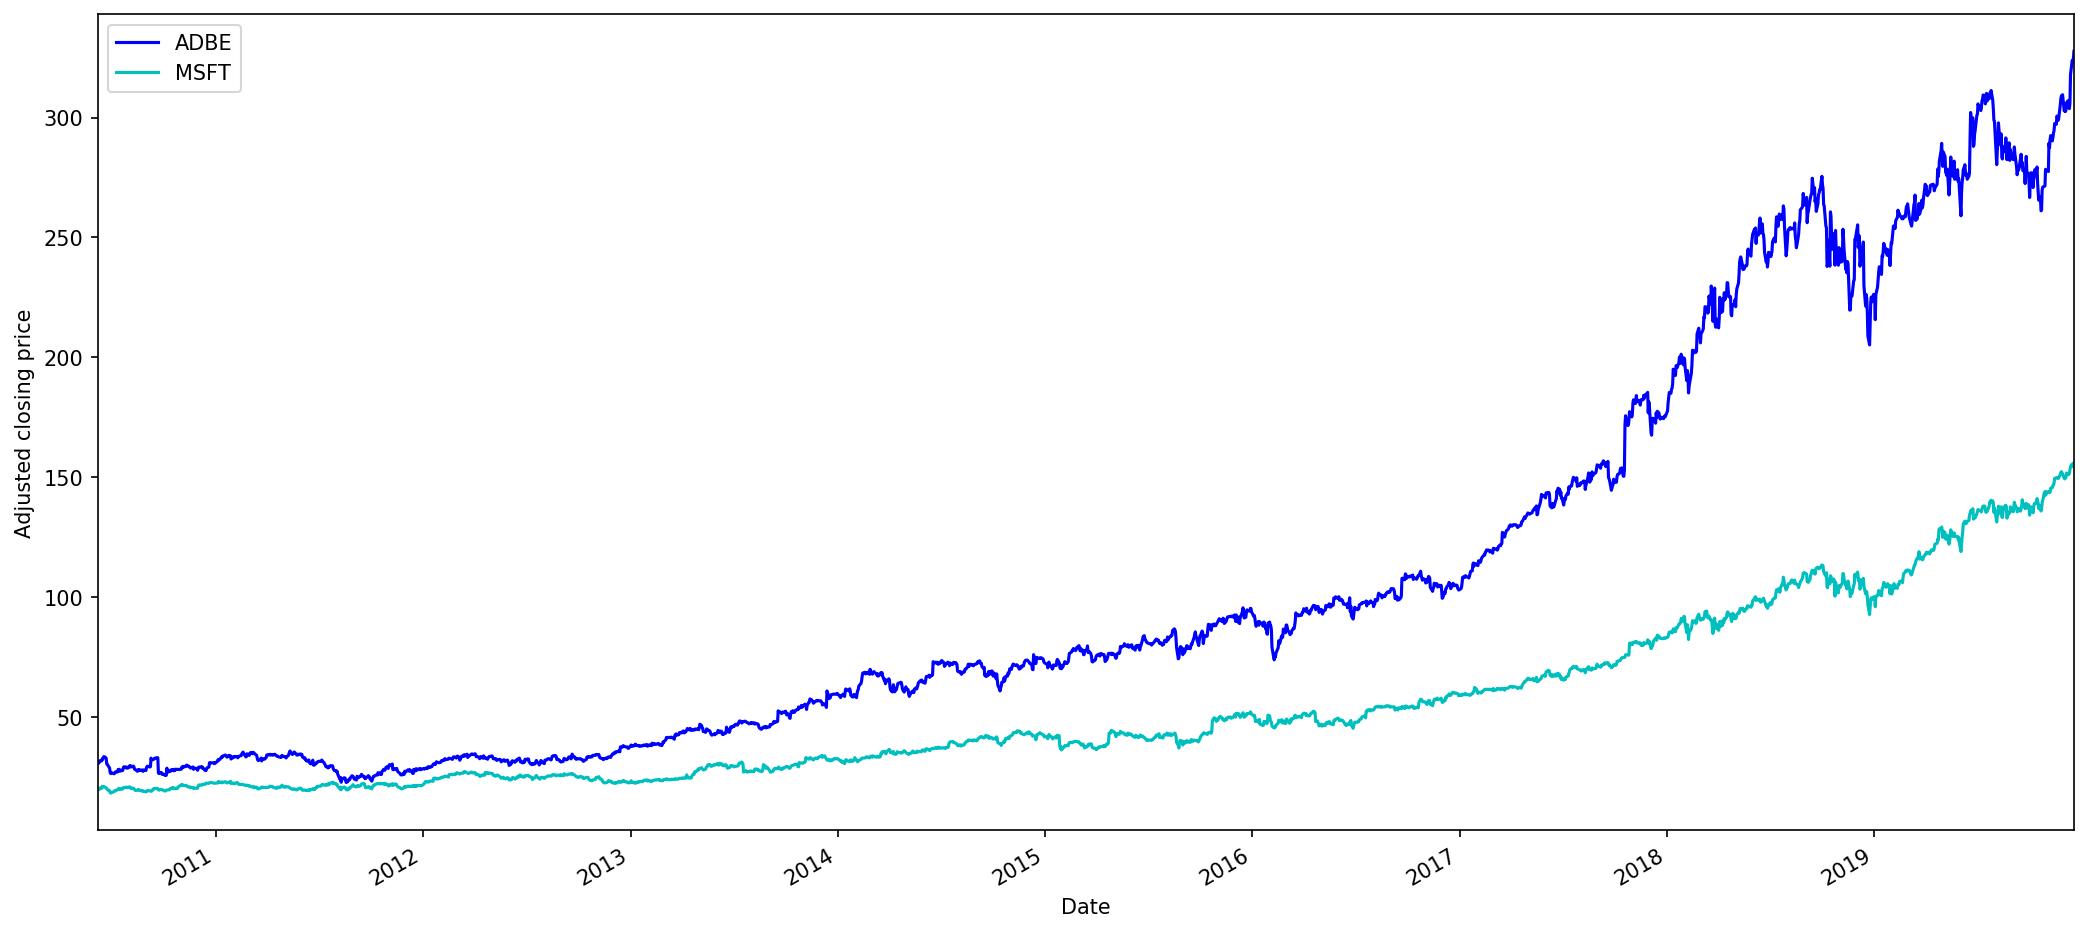

In [126]:
stock1 = 'ADBE'
stock2 = 'MSFT'

#plt.figure(figsize=(18,9))
#S1, S2 = data[stock1], data[stock2]
#S1.plot(color='b')
#S2.plot(color='c')

fig = plt.figure(figsize=(17,8), dpi=150)
ax = plt.gca()
S1, S2 = data[stock1], data[stock2]
S1.plot(color='b', ax=ax)
S2.plot(color='c', ax=ax)
ax.set_ylabel('Adjusted closing price')
ax.legend([stock1, stock2], loc='upper left');

Nice. Like a big brother and a little brother.

# Modeling

### Preparing the data for training

In [103]:
def zscore(S1, S2, long_window, now_window):    
    
    ratios = S1/S2
    
    ma1 = ratios.rolling(window=now_window,
                                center=False).mean()
    ma2 = ratios.rolling(window=long_window,
                                center=False).mean()
    std = ratios.rolling(window=long_window,
                                center=False).std()
    zscore = (ma1 - ma2)/std
    
    return zscore

In [104]:
#now_window = 2
#long_window = 100

def prepare_data(data, now_window, long_window):
    # PREPARING DATA FOR TRAINING
    S1, S2 = data[stock1], data[stock2]
    ratios = S1 / S2
    training_ratio = 1
    split_index = int(len(ratios.index) * training_ratio)
    training_data = ratios[:split_index]
    testing_data = ratios[split_index:]

    ratios_mavg5 = training_data.rolling(window=now_window,
                                   center=False).mean()
    ratios_mavg60 = training_data.rolling(window=long_window,
                                   center=False).mean()
    std_60 = training_data.rolling(window=long_window,
                            center=False).std()
    zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

    Z = zscore(S1, S2, long_window, now_window)
    
    # Remove first 60 rows because they were used to get the rolling means. 
    S1 = S1[long_window:]
    S2 = S2[long_window:]
    Z = Z[long_window:]
    
    return S1, S2, Z

### Model 1: basic pair trading

In [105]:
def model1(S1, S2, Z, initial_investment):
    
    # Start with no money and no positions
    total_value = []
    S1_amounts = []
    starting_price = 0 
    starting_amount = 0
    leftover_money = 0
    countS1 = 0
    countS2 = 0
    started = False
    threshold = 1.7

    for i in range(len(Z)):

        # Buy initial position.
        if not started:
            if Z[i] > threshold:
                starting_price = S2[i]
                starting_amount = initial_investment // starting_price
                countS2 = starting_amount
                leftover_money = initial_investment % starting_price
                started = True
            elif Z[i] < -threshold:
                starting_price = S1[i]
                starting_amount = initial_investment // starting_price
                countS1 = starting_amount
                leftover_money = initial_investment % starting_price
                started = True

        # Sell S1 and buy S2.
        if (Z[i] > threshold) and (countS1 != 0):
            brutto_money = (countS1 * S1[i]) + leftover_money
            countS1 = 0
            countS2 = brutto_money // S2[i]
            leftover_money = brutto_money % S2[i]
        # Sell S2 and buy S1.
        elif (Z[i] < -threshold) and (countS2 != 0):
            brutto_money = (countS2 * S2[i]) + leftover_money
            countS2 = 0
            countS1 = brutto_money // S1[i]
            leftover_money = brutto_money % S1[i]

        S1_amounts.append(countS1)
        total_value.append(S1[i]*countS1 + S2[i]*countS2)
    
    # Dividing the series by the initial amount of stocks bought, in
    # order to find out the value of one 'virtual' stock.
    V = [x / starting_amount for x in total_value]
    # Making the virtuals into a Series with the same datetime indices
    # as S1 and S2 so it can be plotted on the same axis. 
    V = pd.Series(V, S1.index) 
        
    return V, S1_amounts, starting_price

In [122]:
def plot_model_result(V, S1_amounts, starting_price):  

    global S1, S2
    
    # Scaling the series so that the value of the result series is 1 at the initial purchase.
    # This enables to easily see what the relative gain is.
    V /= starting_price
    S1 /= starting_price 
    S2 /= starting_price
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,9), dpi=150)
    fig.subplots_adjust(hspace=0.5)
    
    S1.plot(color='b', ax=ax1, legend=stock1)
    S2.plot(color='c', ax=ax1, legend=stock2)
    V.plot(color='r', ax=ax1, legend='Total value')
    ax1.set_ylabel('Value relative to {}'.format(stock1))
    
    S1_amounts_series = pd.Series(S1_amounts, S1.index)
    S1_amounts_series[60:].plot(color='black', ax=ax2, title='Amount of stock 1')
    
    ax1.legend([stock1, stock2, 'Total value'])
    
    print('Achieved a {:.1f}-fold gain'.format(V[-1]))
    print('This is {:.1f} more than keeping to S1 would have yielded.'.format(V[-1] - S1[-1]))

Achieved a 17.3-fold gain
This is 5.5 more than keeping to S1 would have yielded.


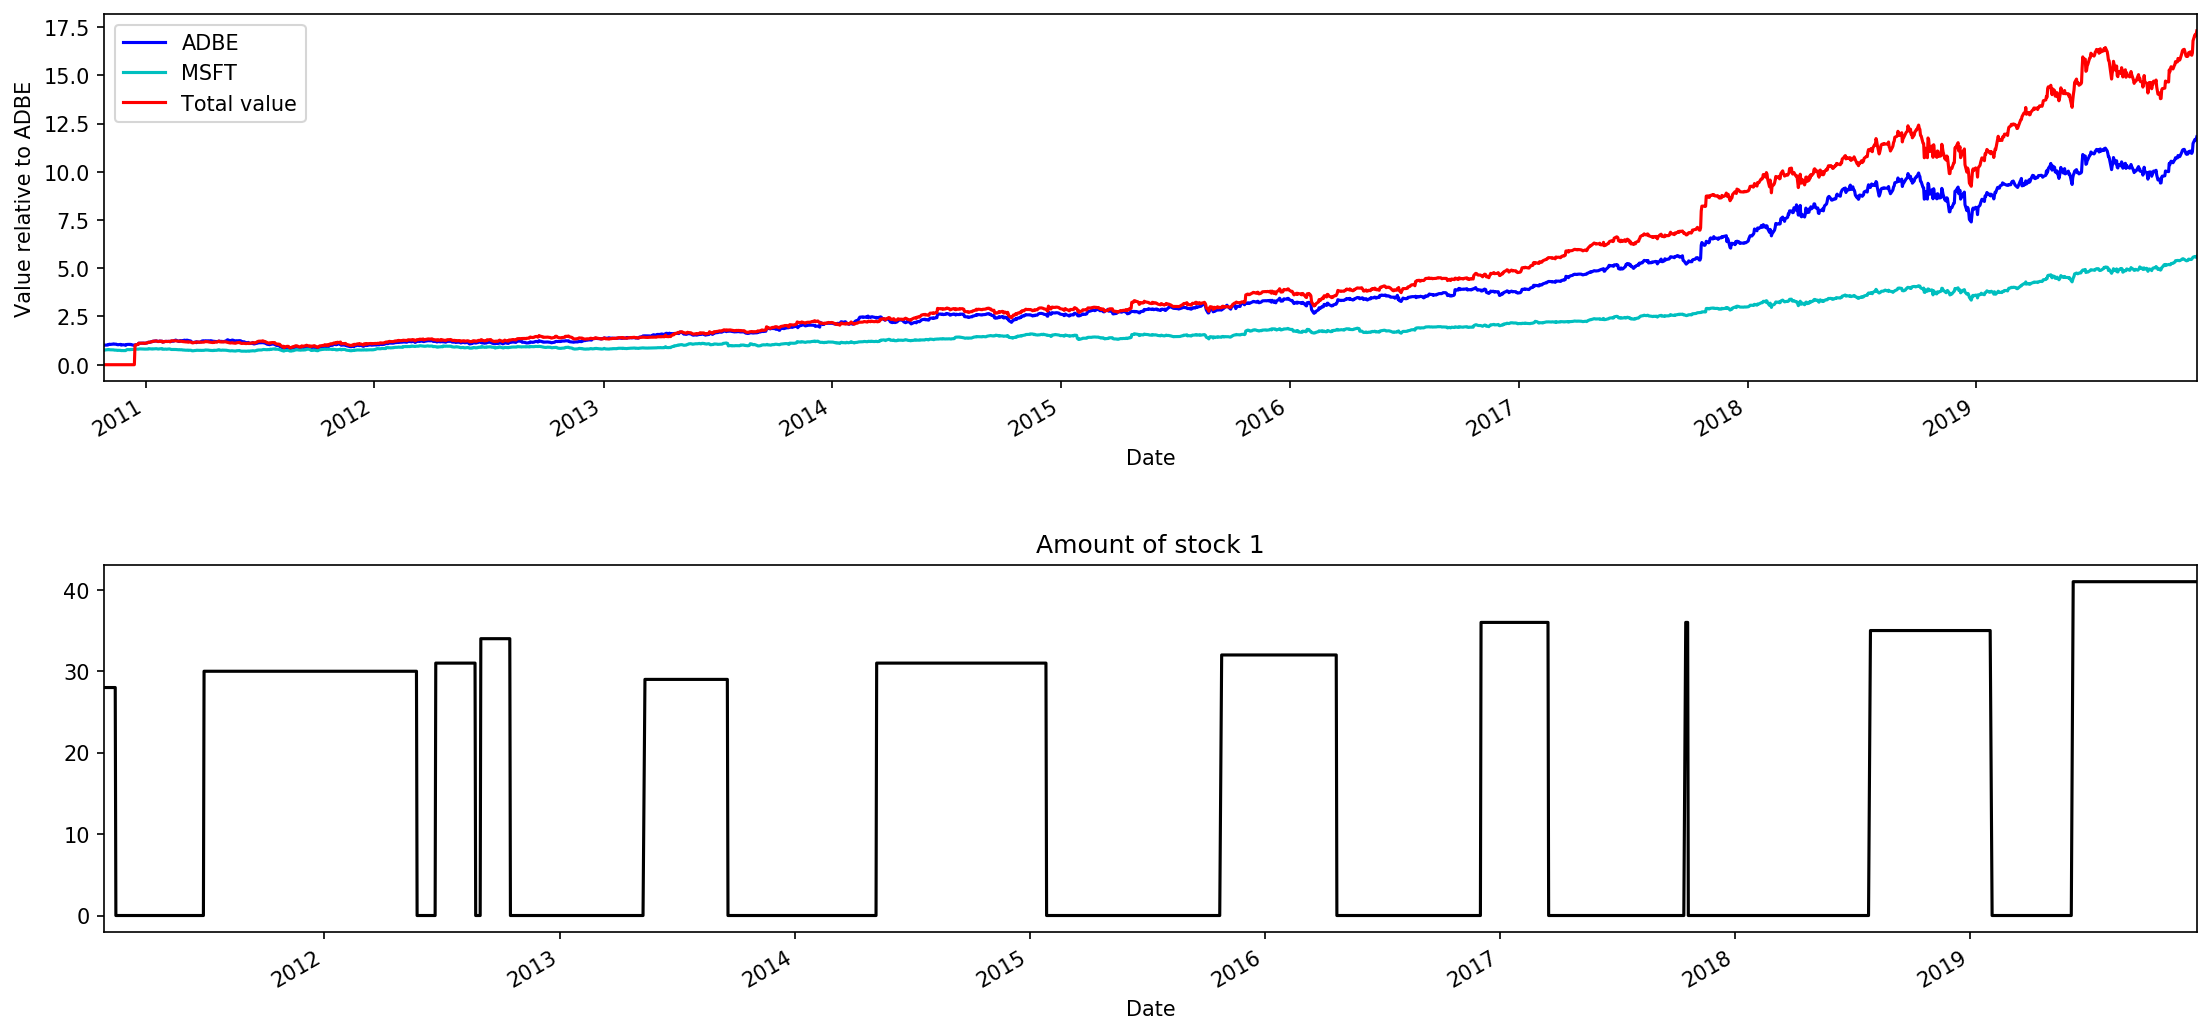

In [123]:
initial_investment = 800 # USD
now_window = 2
long_window = 100
S1, S2, Z = prepare_data(data, now_window, long_window)
V, S1_amounts, starting_price = model1(S1, S2, Z, initial_investment)
plot_model_result(V, S1_amounts, starting_price) 

### Model 2: transaction stretch-out

In this variation, when a buy or sell is triggered, the ensuing bying or selling is spread between a few days. 

Note that having sold one position, we always buy the other on following day, unlike in Model 1 where the two transactions are conducted the same day.

In [25]:
def model2(S1, S2, Z, initial_investment, day_spread, backstop):
    
    # Start with no money and no positions
    total_value = []
    S1_amounts = []
    starting_price = 0 
    starting_amount = 0
    leftover_money = 0
    countS1 = 0
    countS2 = 0
    started = False
    threshold = 1.7

    # These are needed for spreading the buying and selling over several days.
    is_buying = False
    is_selling = False
    days_done = 0
    daily_money_portion = 0
    
    # Buy initial position. 
    starting_price = S1[0]
    starting_amount = initial_investment // starting_price
    countS1 = starting_amount
    leftover_money = initial_investment % starting_price
    
    
    for i in range(len(Z)):

        # Continuing the daily buying or selling only if there either is no backstop,
        # or the z-score is still above 1 or below -1.
        continue_buy_sell = True if ~backstop else (abs(zscore[i]) > threshold)
        
        if (is_buying or is_selling) and continue_buy_sell:
            
            if is_selling:
                total_daily_portion = daily_money_portion + leftover_money
                countS2 += total_daily_portion // S2[i]
                leftover_money = total_daily_portion % S2[i]
            elif is_buying:
                total_daily_portion = daily_money_portion + leftover_money
                countS1 += total_daily_portion // S1[i]
                leftover_money = total_daily_portion % S1[i]
                
            if days_done == (day_spread - 1):
                days_done = 0
                is_selling = False
                is_buying = False
            else:
                days_done += 1

        else:
            # Start buying if the z-score is > 1
            if (Z[i] > threshold) and (countS1 != 0):
                daily_money_portion = (countS1 * S1[i]) / day_spread
                countS1 = 0
                is_selling = True
            # Start buying if the z-score is < 1
            elif (Z[i] < -threshold) and (countS2 != 0):
                daily_money_portion = (countS2 * S2[i]) / day_spread
                countS2 = 0
                is_buying = True

        S1_amounts.append(countS1)
        total_value.append(S1[i]*countS1 + S2[i]*countS2)
    
    # Dividing the series by the initial amount of stocks bought, in
    # order to find out the value of one 'virtual' stock.
    V = [x / starting_amount for x in total_value]
    # Making the virtuals into a Series with the same datetime indices
    # as S1 and S2 so it can be plotted on the same axis. 
    V = pd.Series(V, S1.index) 
        
    return V, S1_amounts, starting_price

In [13]:
initial_investment = 800 # USD
now_window = 3
long_window = 25
day_spread = 2
backstop=True

S1, S2, Z = prepare_data(data, now_window, long_window)
V, S1_amounts, starting_price = model2(S1, S2, Z, initial_investment, day_spread, backstop)
plot_model_result(V, S1_amounts, starting_price) 

NameError: name 'starting_amount' is not defined

# Optimization

Finding the optimal length of the *now window* and the *long window*, by plotting a heatmap of them against the last ratio of the virtual value to the actual value of the upper stock; in other words, the gain in value using these models relative to simply holding on to the upper stock. In the case of Model 2 I will also find the best value for *day_spread*.

In [26]:
# These return the last ratio of the virtual value to the actual value of the upper stock, 
def model1_result(i,j):
    global initial_investment
    global data
    S1, S2, Z = prepare_data(data, params['now_window'][int(i)], params['long_window'][int(j)])
    V, S1_amounts, _ = model1(S1, S2, Z, initial_investment)
    return V[-1]/S1[-1]


def model2_result(i,j,spread_days):
    global initial_investment
    global data
    S1, S2, Z = prepare_data(data, params['now_window'][int(i)], params['long_window'][int(j)])
    V, S1_amounts, _ = model2(S1, S2, Z, initial_investment, spread_days, backstop=False)
    return V[-1]/S1[-1]

In [77]:
initial_investment = 800 # USD

params = {
            'now_window': np.arange(1,9,1),
            'long_window': np.arange(10,100,3)
         }

def windows_matrix(spread_days):

    ratio_matrix = np.array([])
    title = ''
    
    if spread_days == 0:
        title = 'Heatmap of the gain using the Model 1.'
        ratio_matrix = np.fromfunction(np.vectorize(model1_result),
                                       (len(params['now_window']), len(params['long_window'])))
    else:
        title = 'Heatmap of the gain using Model 2 with a spread of {} days.'.format(spread_days)
        ratio_matrix = np.fromfunction(lambda i,j: np.vectorize(model2_result)(i,j,spread_days),
                                       (len(params['now_window']), len(params['long_window'])))
        
    fig, ax = plt.subplots(figsize=(20,5), dpi=150)
    ax = sns.heatmap(ratio_matrix, 
                     cmap='seismic', 
                     xticklabels=params['long_window'], 
                     yticklabels=params['now_window'],
                     center=1,
                     vmin=0, vmax=3,
                     ax=ax)
    plt.xlabel('Long window')
    plt.ylabel('Short window')
    plt.title(title)

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_aspect("equal")
    
    label_freq = 3
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible((ind % label_freq) == 0)

/Users/mikaelkoskela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


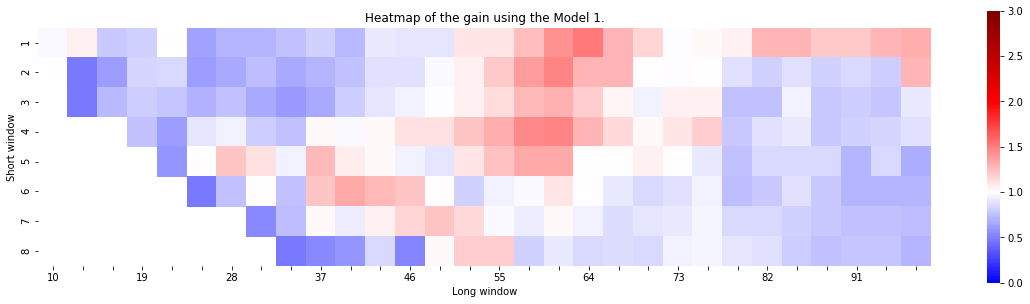

In [76]:
windows_matrix(0)

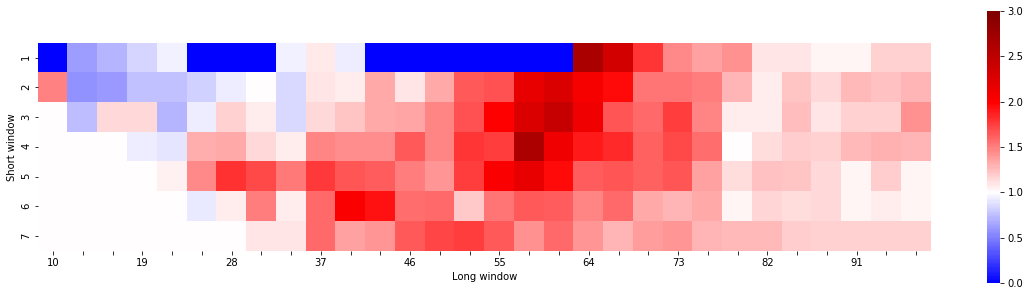

In [35]:
windows_matrix(1)

This model's superiority is visible not only as the greater darkness of the red, but also as the lower risk in the region with a long window, as it is red instead of blue. The difference between Model 2 with no day spread (i.e., a spread_days of 1) and Model 1 is that in the latter, we buy the other position on the same day as we sold the other, while in the former we buy it on the following day. It is remarkable how much the wait of one day affect the result). 

Note the couple ominous gulfs of 0 at the top of the heatmap. Of the two optimal points, it would be far riskier to choose the (64, 1) point than the (56, 4) point, as in the former case the investment could easily slip into oblivion.

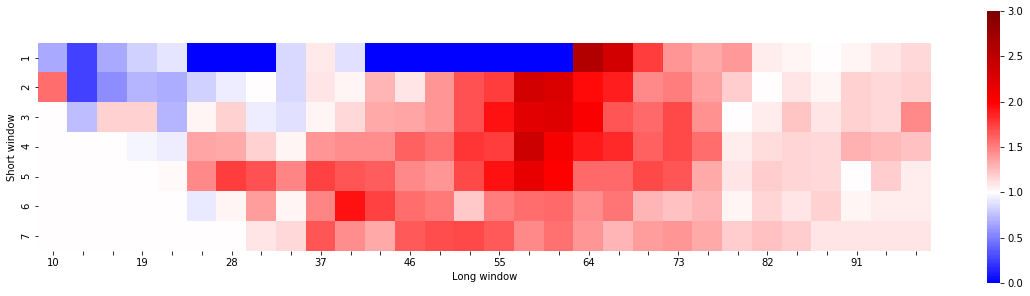

In [36]:
windows_matrix(2)
windows_matrix(3)

Increasing the windows hence has an adverse effect on the outcome. That is, conducting each transaction in one go is superior to spreading them out.

Lastly, it is worth checking out how the model performs with another pair. Choosing the pair with the lowest of the p-values, that is, highest cointegration: **AVGO** and **BSX**

3.4146154438131804


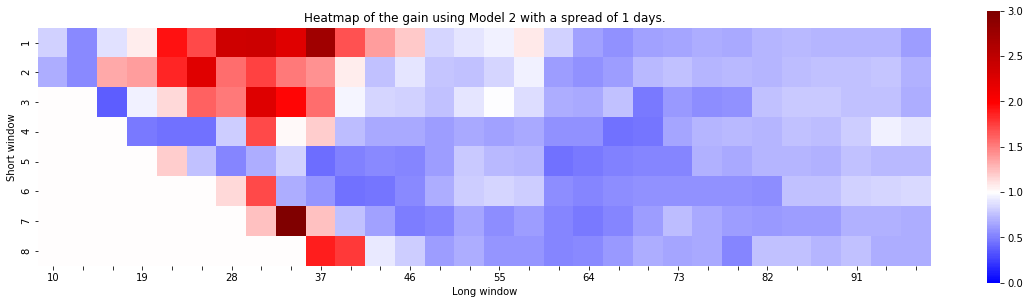

In [80]:
windows_matrix(1)

The optimal point, (36, 1) yields a boost of as much as 3.41 (exceeding the heatmap's color range, which I calibrated for the original pair). But once again, it is perched precariously next to blueness. If you are risk-averse, you should rather choose the far mellower (37, 1) point.

# Enhancement ideas

Todo once I get around to it.

* Try buying N days after selling.
* Find out about these models' stability regarding the starting point, ie. initial purchase.
* Find the triggers by NN instead / in combination with the threshold method.